In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os 
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from sklearn.utils import compute_class_weight

In [9]:
train_dir = '../../src/data/train'
validation_dir = '../../src/data/val'
test_dir = '../../src/data/test'


dagenerator = ImageDataGenerator(rescale=1./255)
target_size = (64, 64)
batch_size = 10

num_of_test_samples = len(glob.glob('../../src/data/test/*/*.jpg'))
num_of_val_samples = len(glob.glob('../../src/data/val/*/*.jpg'))


In [10]:
#
train_generator = dagenerator.flow_from_directory(
        train_dir,
        target_size= target_size, 
        batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(
        validation_dir,
        target_size= target_size, 
        batch_size = num_of_val_samples,
        shuffle=False)

test_generator = dagenerator.flow_from_directory(
        test_dir,
        target_size= target_size, 
        batch_size = num_of_test_samples, #All images in test set 
        shuffle=False)

Found 4116 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.
Found 1296 images belonging to 4 classes.


In [5]:
earlystopping = EarlyStopping(monitor = 'val_acc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

filepath = '../../src/best_weights.hdf5'
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

train_generator.classes
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
dict_class_weights = dict(enumerate(class_weights))
print(dict_class_weights)

{0: 1.7381756756756757, 1: 25.097560975609756, 2: 0.5021961932650073, 3: 0.7175732217573222}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [11]:

#model 1
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics= ['acc', 'AUC'])

history = model.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=200)

Epoch 1/200
412/412 [==============================] - ETA: 0s - loss: 1.4035 - acc: 0.2128 - auc: 0.5291
Epoch 00001: val_acc did not improve from 0.34888
412/412 [==============================] - 7s 17ms/step - loss: 1.4035 - acc: 0.2128 - auc: 0.5291 - val_loss: 1.3976 - val_acc: 0.0107 - val_auc: 0.2442
Epoch 2/200
410/412 [============================>.] - ETA: 0s - loss: 1.3981 - acc: 0.1228 - auc: 0.3848
Epoch 00002: val_acc did not improve from 0.34888
412/412 [==============================] - 7s 17ms/step - loss: 1.3962 - acc: 0.1224 - auc: 0.3844 - val_loss: 1.3906 - val_acc: 0.0107 - val_auc: 0.3406
Epoch 3/200
411/412 [============================>.] - ETA: 0s - loss: 1.3937 - acc: 0.1961 - auc: 0.4162
Epoch 00003: val_acc did not improve from 0.34888
412/412 [==============================] - 8s 19ms/step - loss: 1.3934 - acc: 0.1956 - auc: 0.4160 - val_loss: 1.3835 - val_acc: 0.3489 - val_auc: 0.5948
Epoch 4/200
410/412 [============================>.] - ETA: 0s - loss:

In [42]:
from keras.models import load_model
model = load_model(filepath)

In [38]:
num_of_val_samples // batch_size +1

103

In [43]:
def results(model,history, generator, samples, batch_size):
    Y_pred = model.predict_generator(generator, samples // batch_size +1) # so it lines up with the batches
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Mild','Moderate','None','Very Mild']
    print('------------------------Confusion Matrix---------------------------')
    conf = confusion_matrix(generator.classes, y_pred, normalize='true')
    ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
    ax.set(xlabel='Predicted', ylabel='Actual')
    
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    ax = ax.ravel()

    for i, j in enumerate(['auc', 'loss', 'acc']):
        ax[i].plot(history.history[j])
        ax[i].plot(history.history['val_' + j])
        ax[i].set_title('Model {}'.format(j))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(j)
        ax[i].legend(['train', 'val'])
        
    return

------------------------Confusion Matrix---------------------------


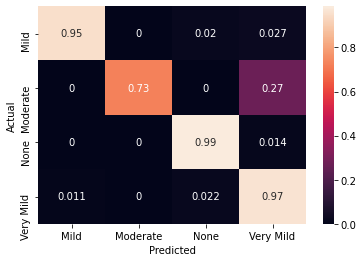

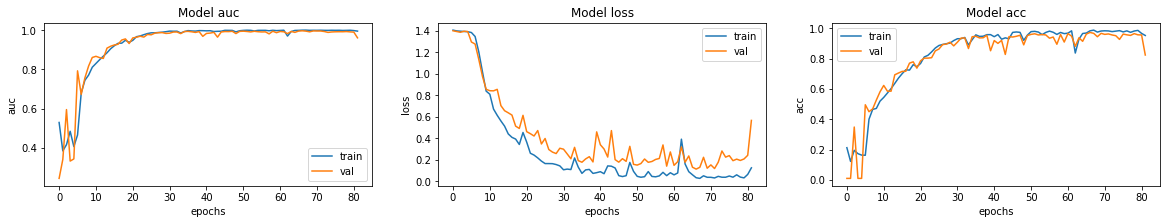

In [40]:
results(model, history, val_generator, num_of_val_samples, batch_size)

------------------------Confusion Matrix---------------------------


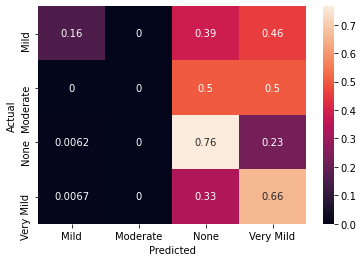

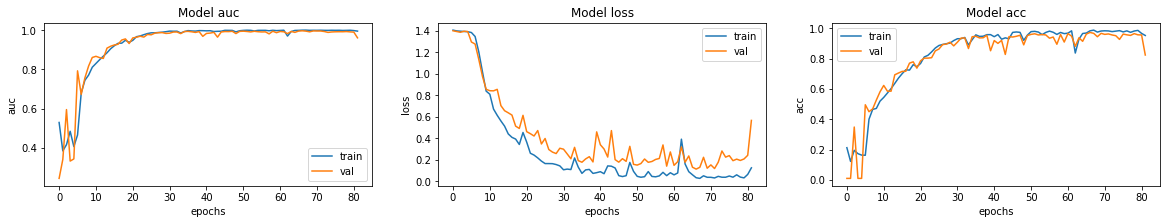

In [41]:
results(model,history, test_generator, num_of_test_samples, batch_size)

In [ ]:
model_RMS4 = Sequential()

model_RMS4.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
               strides=(2,2), input_shape = [208,176,1]))
model_RMS4.add(MaxPooling2D(2))
model_RMS4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(MaxPooling2D(2))
model_RMS4.add(Flatten())
model_RMS4.add(Dense(64, activation = 'relu'))
model_RMS4.add(Dropout(0.4))
model_RMS4.add(Dense(32, activation = 'relu'))
model_RMS4.add(Dropout(0.4))
model_RMS4.add(Dense(4, activation = 'softmax'))
    